In [47]:
#Must Haves
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import datetime

#Data Processing and Stats!
import pandas as pd
import numpy as np

#Regex
import re

#For Image Plots
import matplotlib.image as im
%matplotlib inline
import matplotlib.pyplot as plt

#File Org
import glob
import os

## Selenium! 

https://www.selenium.dev/selenium/docs/api/py/


### Browser Drivers:

https://chromedriver.chromium.org/downloads

https://github.com/mozilla/geckodriver

### Launch!

In [4]:
geckoDriverPath = '/Users/matthewmitchell/Documents/Projects/Tools/Python/Scraping/geckodriver'
driver = webdriver.Firefox(executable_path=geckoDriverPath)

In [ ]:
driver.get("https://webcams.nyctmc.org/cameras-list")

## XPath Selections Are Your Friend!

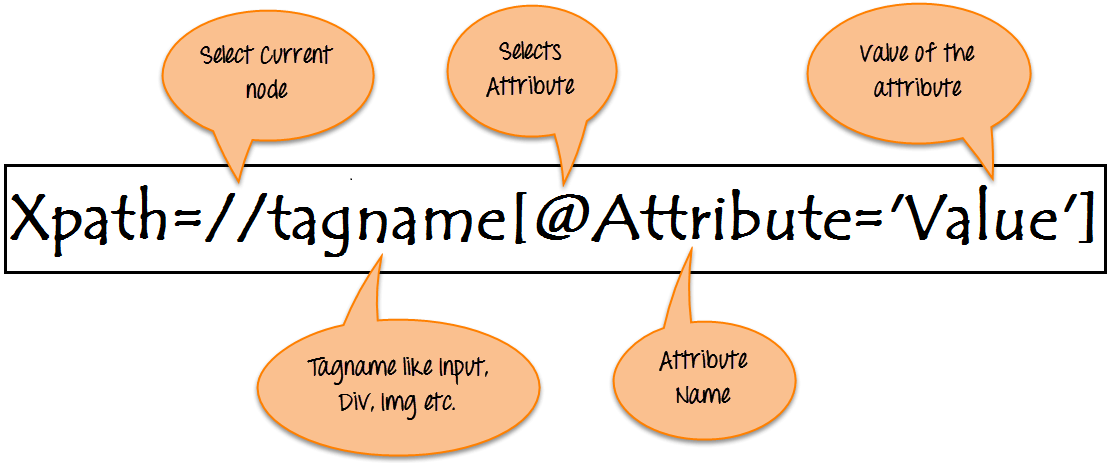

In [ ]:
div = 
button = 


## Beautiful Soup

In [5]:
cur_html = driver.page_source

In [6]:
soup = BeautifulSoup(cur_html)
print(soup.prettify()[:500])

<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Real Time Traffic Information
  </title>
  <base href="/"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <link href="favicon.ico" rel="icon" type="image/x-icon"/>
  <link href="styles.19836e003f9a9243.css" rel="stylesheet"/>
  <style>
   .navigation[_ngcontent-gxj-c113]{background:var(--navigation-panel-bg)}.header[_ngcontent-gxj-c113], .footer[_ngcontent-gxj-c113]{z-index:30}.navigation[_ngcontent-gxj-c


In [12]:
n_children = 0
for i in soup.children:
    n_children += 1
#     if n_children <= 5:
#         print(i.tag, type(i))
n_children    

1

In [13]:
class_name = "mat-checkbox-inner-container mat-checkbox-inner-container-no-side-margin"
cam_checkboxes = driver.find_elements_by_class_name(class_name)
print(len(cam_checkboxes))

0


In [53]:
body = driver.find_element_by_tag_name('body')
body = body.find_element_by_tag_name('body')
main_div = body.find_element_by_tag_name('div')

app_nav = main_div.find_element_by_tag_name('app-navigation')

cam_list_pc = main_div.find_element_by_xpath("//div[@class='g-view-wrapper g-flex ng-tns-c113-0']")
# app_cam_list = div2.find_element_by_tag_name('app-camera-list')
cam_list_pc.get_attribute('class') #g-view-wrapper g-flex ng-tns-c113-0
cam_list = cam_list_pc.find_element_by_tag_name('app-cameras-list')
tbody = cam_list.find_element_by_tag_name('tbody')
trows = tbody.find_elements_by_tag_name('tr')

table_addresses = []
for trow in trows:
    a , b = get_address_borough(trow)
    table_addresses.append((a,b))
#Format as DataFrame (like excel spreadsheet)
df = pd.DataFrame(table_addresses)
df.columns = ['Address','Borough']
df.head()

,Address,Borough
0,1 Ave @ 110 St,Manhattan
1,1 Ave @ 124 St,Manhattan
2,1 Ave @ 14 St,Manhattan
3,1 Ave @ 23 St,Manhattan
4,1 ave @ 40 st,Manhattan


In [45]:
def get_address_borough(trow):
    cb_cell, a_cell, b_cell =  trow.find_elements_by_tag_name('td')[:3]
    return (a_cell.text, b_cell.text)

In [ ]:
def parse_rows():
    #Collect Data
    #Check checkbox?

In [43]:
trow = trows[0]
cb_cell, a_cell, b_cell =  trow.find_elements_by_tag_name('td')[:3]
print(a_cell.text)
print(b_cell.text)
checkbox = cb_cell.find_element_by_tag_name('mat-checkbox')
#     print(td.text, "\n")

1 Ave @ 110 St
Manhattan


In [44]:
checkbox.click()

In [ ]:
def parse_row_text(row_text):
    boroughs = ['Manhattan','Bronx','Staten Island','Queens','Brooklyn']
    borough = [b for b in boroughs if b in row_text][0]
    address = row_text.replace(borough,"")
    return address, borough

In [27]:
sub_divs = main_div.find_elements_by_tag_name('div')
print(len(sub_divs))

67


In [29]:
for sub_div in sub_divs[:5]:
    print(sub_div.get_attribute('class'))

g-view-container g-flex-column
nav-overlay ng-tns-c113-0 ng-star-inserted
g-view-wrapper g-flex ng-tns-c113-0
g-view-container g-flex-column ng-tns-c103-1 ng-trigger ng-trigger-fadeAnimation
g-flex-row g-view-toolbar mdc-elevation--z3 ng-tns-c103-1


In [ ]:
sub

In [25]:
print("Class: {}".format(main_div.get_attribute('class')))
print("Tag type: {}".format(main_div.tag_name))

Class: g-view-wrapper g-flex g-flex-row ng-tns-c113-0
Tag type: div


In [26]:
for el in main_div.anonymous_children:
    print(el.tag_name)

InvalidSelectorException: Message: Strategy not supported: anon


In [14]:
def match_class(target):
    target = target.split()
    def do_match(tag):
        try:
            classes = dict(tag.attrs)["class"]
        except KeyError:
            classes = ""
        classes = classes.split()
        return all(c in classes for c in target)
    return do_match

In [15]:
matches = soup.findAll(match_class(class_name))
print(len(matches))

AttributeError: 'list' object has no attribute 'split'

In [ ]:
soup.find

In [ ]:
<span class="mat-checkbox-inner-container mat-checkbox-inner-container-no-side-margin"><input type="checkbox" class="mat-checkbox-input cdk-visually-hidden" id="mat-checkbox-1-input" tabindex="0" aria-checked="false"><span matripple="" class="mat-ripple mat-checkbox-ripple mat-focus-indicator"><span class="mat-ripple-element mat-checkbox-persistent-ripple"></span></span><span class="mat-checkbox-frame"></span><span class="mat-checkbox-background"><svg version="1.1" focusable="false" viewBox="0 0 24 24" aria-hidden="true" class="mat-checkbox-checkmark"><path fill="none" stroke="white" d="M4.1,12.7 9,17.6 20.3,6.3" class="mat-checkbox-checkmark-path"></path></svg><span class="mat-checkbox-mixedmark"></span></span></span>

### Save HTML to Disk

In [ ]:
time = 
filename = "Driver_HTML_As_of_{}".format(time_now)
with open(filename, "wb") as f:
    f.write(cur_html)

In [ ]:
soup.find('h1')

In [ ]:
headers = soup.find_all('h1')
print(len(headers))
h = headers[0]
h

## Type, Click and Scroll!

### Typing

### Clicking

### Scrolling

In [ ]:
def scroll(driver, up=False, amount=15):
    """15 is a little bit of scrolling"""
    current_position = driver.execute_script("return document.documentElement.scrollTop")
    for i in range(amount):
        if up:
            y = current_position - i*57
        else:
            y = current_position + i*57
        driver.execute_script("window.scrollTo(0, {})".format(y))
        time.sleep(np.random.uniform(low=0.01, high=.05))

In [ ]:
for i in range(10):
    scroll(driver)
    time.sleep(2) #Small Pause.

## Images

In [ ]:
driver.save_screenshot("CurrentWindow.png")

In [ ]:
window_size = driver.get_window_size()
x = window_size['width']
y = window_size['height']

driver.get_screenshot_as_file('temp.png')
img = im.imread('temp.png')
plt.figure(figsize=(x//10, y//10))
plt.imshow(img)

## Saving and Storing Your Data

In [ ]:
#Lists! l = []
#Dictionaries! d = {'a':"Apple", 'b':"Banana"}

## Change Window Size

In [ ]:
driver.set_window_rect(x=960, y=27, width=960, height=1025)

## Error Handling!

In [ ]:
try:
    pass #Do something here
except Exception as e:
    print("Oops I hit an exception!!")
    time.sleep(30) #You should probably wait a second....
    continue #Onwards!

## Thoughts + Recommendations: 

1. Start Small!
2. Check Your Work
3. Build Iteratively
4. Use a VPN
5. SLOW DOWN!!!! - DON'T GET BLACKLISTED
6. Cache Pages! (You can update your parsing logic later!)
7. JS and React pages get more challenging

## Other Resources:

#### Other Scraping Resources:
* [Requests Documentation](https://docs.python-requests.org/en/latest/index.html)
* [Scrapy](https://scrapy.org/)

#### Regex:
* [Rexegg - Regex Resources](https://www.rexegg.com/)
* [Regex Documentation](https://docs.python.org/3/howto/regex.html)
* [Regex Cheat Sheet](https://www.debuggex.com/cheatsheet/regex/python)